<a href="https://colab.research.google.com/github/AnishaA-git/Fake-News-Spam/blob/master/HW_8_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Week 8

Article: https://link.springer.com/content/pdf/10.1007/s40747-021-00552-1.pdf


**Dataset:**
 1. Fake News dataset <br>(https://www.kaggle.com/manasvik/spam-check/data)
 2. GoogleNews API dataset

### Process
- Load the Data (Fake News Dataset)
- Distillation Process
    - Data Cleaning and Text Preprocessing
    - Visualization

Features Added:
- **Feature 1 :** Word Frequency
- **Feature 2 :** Readability Score

Content Based:
- **Micro Factor 1 :** Profanity Check
- **Micro Factor 2 :** Parts of Speech Adjectives
- **Micro Factor 3 :** Parts of Speech Adverbs


#### Enrichment Dataset Details
- LDA Topic Modeling
- PoliticalFact Fake news and Real News Content 
- Spam Dictionary 



In [ ]:
import pandas as pd
import numpy as np
import csv
import gensim
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from plotly.offline import *
import plotly
import io
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from nltk.corpus import stopwords
from string import punctuation
from scipy import sparse
from wordcloud import WordCloud, STOPWORDS
from scipy import stats
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **Fake News Data Set**

# **DATA IMPORTING**

In [ ]:
# Kaggle Fake news dataset
url="https://media.githubusercontent.com/media/AnishaA-git/Fake-News-Spam/master/fake.csv"
file=requests.get(url).content
fake_news=pd.read_csv(io.StringIO(file.decode('utf-8')),sep=',')

In [ ]:
print(fake_news.shape)

(12999, 20)


In [ ]:
print(fake_news.describe())
fake_news.head()

       ord_in_thread   domain_rank  ...      comments        shares
count   12999.000000   8776.000000  ...  12999.000000  12999.000000
mean        0.891530  38092.996582  ...      0.038311     10.831833
std         6.486822  26825.487454  ...      0.827335     79.798949
min         0.000000    486.000000  ...      0.000000      0.000000
25%         0.000000  17423.000000  ...      0.000000      0.000000
50%         0.000000  34478.000000  ...      0.000000      0.000000
75%         0.000000  60570.000000  ...      0.000000      0.000000
max       100.000000  98679.000000  ...     65.000000    988.000000

[8 rows x 8 columns]


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


# **DATA PRE-PROCESSING**

In [ ]:
column_names = list(fake_news.columns)
print(column_names)
for column in column_names:
    if fake_news[column].count()<len(fake_news):
        print(column,fake_news[column].count())     
        
fake_news.loc[fake_news['text'].isnull(),'text'] = 'unknown'
fake_news.loc[fake_news['country'].isnull(),'country'] = 'US' 
fake_news.loc[fake_news['author'].isnull(),'author'] = fake_news.loc[fake_news['author'].isnull(),'country']
fake_news.loc[fake_news['thread_title'].isnull(),'thread_title'] = ''
fake_news.loc[fake_news['domain_rank'].isnull(),'domain_rank'] = np.nanmedian(np.array(fake_news['domain_rank'])) 

['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text', 'language', 'crawled', 'site_url', 'country', 'domain_rank', 'thread_title', 'spam_score', 'main_img_url', 'replies_count', 'participants_count', 'likes', 'comments', 'shares', 'type']
author 10575
title 12319
text 12953
country 12823
domain_rank 8776
thread_title 12987
main_img_url 9356


Since features play a BIG role in the prediction accuracy I will be using the following features:

1. From tweet text
*   number of words
*   similarity score between tweet text and title of URL (using tfidf)
2. From tweet metadata
*   Author name
*   likes
*   comments
*   shares
*   replies_count
*   country
*   participants_count
*   domain_rank
*   language


# Adding Feature 1 - Word Count

In [ ]:
# starting with features from tweet content

pstem = PorterStemmer()
stop = set(stopwords.words('english'))

def stemmer(text):
    wordlist = text.strip().split()
    pstem = PorterStemmer()
    j = '';
    for word in wordlist:
        try:
            j = j+pstem.stem(word)+' '
        except: 
            print(text)
    return j

#converting all texts and thread_titles to lowercase
fake_news['clean_text'] = fake_news['text'].map(lambda x: re.sub(r'[^a-z ]','',x.lower()))
fake_news['clean_text'] = fake_news['clean_text'].map(lambda x: ' '.join([word for word in x.strip().split() if word not in stop ]))
fake_news['clean_text'] = fake_news['clean_text'].map(lambda x: stemmer(x))
fake_news['clean_thread'] = fake_news['thread_title'].map(lambda x: re.sub(r'[^a-z ]','',x.lower()))
fake_news['clean_thread'] = fake_news['clean_thread'].map(lambda x: ' '.join([word for word in x.strip().split() if word not in stop ]))
fake_news['clean_thread'] = fake_news['clean_thread'].map(lambda x: ' '.join([pstem.stem(word) for word in x.strip().split()]))

#feature1- number of words
fake_news['num_words'] = fake_news['clean_text'].map(lambda x: len(str(x).strip().split()))

# **TF-IDF & SIMILARITY**

In [ ]:
#feature2 - similarity score between tweet text and title 
def similarity(t1,t2):
    t = [t1,t2]
    tfidf_vectorizer = TfidfVectorizer()
    try:
        vectors = tfidf_vectorizer.fit_transform(t)
        vectors = vectors.toarray()
        sim = cosine_similarity(vectors[0].reshape(1,-1),vectors[1].reshape(1,-1))[0]
    except:
        sim = 0
    return sim

fake_news['similarity'] = [similarity(b['clean_text'],b['clean_thread']) for (a,b) in fake_news.iterrows()]
fake_news['similarity'].describe() 

count    12999.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: similarity, dtype: float64

In [ ]:
fake_news['index'] = fake_news.index
data = fake_news
train_lda = data[['clean_text', 'index','clean_thread']]
train_lda.head(4)

,clean_text,index,clean_thread
0,print pay back money plu interest entir famili...,0,muslim bust stole million govt benefit
1,attorney gener loretta lynch plead fifth barra...,1,attorney gener loretta lynch plead fifth
2,red state fox news sunday report morn anthoni ...,2,break weiner cooper fbi hillari email investig
3,email kayla mueller prison tortur isi chanc re...,3,pin drop speech father daughter kidnap kill is...


In [ ]:
processed_docs = train_lda['clean_text'].map(lambda doc: doc.split(" "))
processed_docs[:4]

0    [print, pay, back, money, plu, interest, entir...
1    [attorney, gener, loretta, lynch, plead, fifth...
2    [red, state, fox, news, sunday, report, morn, ...
3    [email, kayla, mueller, prison, tortur, isi, c...
Name: clean_text, dtype: object

# Adding Feature 2- Readability Score

In [ ]:
!pip install readability

In [ ]:
import readability
count=0
readability_list = []
final_list = []
txt = fake_news['clean_text']
for i in txt:
  if not i.strip():
    final_list.append(0)
  else:
    results = readability.getmeasures(i, lang='en')
    readability_list = results['readability grades']['FleschReadingEase']
    final_list.append(readability_list)
fake_news['readability_score'] = final_list
fake_news.describe()

,ord_in_thread,domain_rank,spam_score,replies_count,participants_count,likes,comments,shares,num_words,similarity,index,readability_score
count,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.0,12999.000000,12999.000000
mean,0.891530,36918.588507,0.026122,1.383183,1.727518,10.831833,0.038311,10.831833,349.249096,0.0,6499.000000,-302.373136
std,6.486822,22106.012346,0.122889,9.656838,6.884239,79.798949,0.827335,79.798949,507.004001,0.0,3752.632409,515.207393
min,0.000000,486.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-12247.090717
25%,0.000000,23677.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,92.000000,0.0,3249.500000,-393.709192
50%,0.000000,34478.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,216.000000,0.0,6499.000000,-166.012762
75%,0.000000,43665.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,439.000000,0.0,9748.500000,-41.293258
max,100.000000,98679.000000,1.000000,309.000000,240.000000,988.000000,65.000000,988.000000,12135.000000,0.0,12998.000000,205.820000


In [ ]:
def ReadabilityCategorize(x):
    if x<-302:
        return 0
    elif x>=-302:
        return 1
    else:
        return 0
    
fake_news.insert(25, "readability_cat", fake_news.apply(lambda row: ReadabilityCategorize(row['readability_score']), axis=1))
fake_news

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_cat,readability_score
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,1,18.531957
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,1,-115.928659
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,1,-74.141154
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,1,43.206897
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,1,-155.693776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,allow put dog face top real face b sound right...,snapchat rais billion ipo valu compani much bi...,12,0,12994,1,110.055000
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,wait till see happen valuat releas featur put ...,snapchat rais billion ipo valu compani much bi...,12,0,12995,1,74.805000
12996,6995d1aa9ac99926106489b14b5530e85358059a,4,major major maj...,2016-10-27T00:06:00.000+03:00,NaN,I'm waiting for the one that puts a pussy on m...,english,2016-10-27T00:37:46.244+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,im wait one put pussi face,snapchat

# **LDA TOPIC MODELLING**

In [ ]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
tokenized_docs_local = fake_news['clean_text'].map(get_word_tokens)

In [ ]:
def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('Dictionary Words and Maximum occurences')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

In [ ]:

def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n BOW Vector First Item')
    print(bow_doc_local_0)
    print('\n Preview BOW')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

In [ ]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n TF-IDF Vector First Item')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

In [ ]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

In [ ]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

In [ ]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

In [ ]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [ ]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(fake_news,'clean_text')

Dictionary Words and Maximum occurences
0 
1 anoth
2 asap
3 back
4 benefit
5 bust
6 came
7 case
8 commit
9 control
10 deport

 BOW Vector First Item
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (39, 1), (40, 1)]

 Preview BOW
Word 0 ("anoth") appears 1 time.
Word 1 ("asap") appears 1 time.
Word 2 ("back") appears 1 time.
Word 3 ("benefit") appears 1 time.
Word 4 ("bust") appears 1 time.
Word 5 ("came") appears 1 time.
Word 6 ("case") appears 1 time.
Word 7 ("commit") appears 1 time.
Word 8 ("control") appears 1 time.
Word 9 ("deport") appears 1 time.
Word 10 ("entir") appears 1 time.
Word 11 ("everyon") appears 1 time.
Word 12 ("famili") appears 1 time.
Word 13 ("four") appears 1 time.
Word 14 ("fraud") appears 1 time.
Word 16 ("govern") 

In [ ]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['clinton', 'email', 'investig', 'state', 'hillari', 'report', 'comey', 'said', 'time', 'would']
1::['clinton', 'trump', 'hillari', 'presid', 'email', 'campaign', 'would', 'state', 'elect', 'donald']
2::['trump', 'elect', 'vote', 'state', 'peopl', 'clinton', 'democrat', 'hillari', 'american', 'said']
3::['russia', 'state', 'would', 'syria', 'govern', 'russian', 'presid', 'said', 'countri', 'also']
4::['peopl', 'govern', 'state', 'pipelin', 'said', 'would', 'forc', 'american', 'like', 'attack']
5::['para', 'russian', 'email', 'state', 'como', 'clinton', 'russia', 'said', 'would', 'estado']
6::['like', 'trump', 'make', 'american', 'peopl', 'time', 'news', 'state', 'mani', 'world']
7::['obama', 'state', 'govern', 'would', 'peopl', 'year', 'presid', 'nation', 'bank', 'world']
8::['peopl', 'world', 'state', 'time', 'like', 'year', 'would', 'nation', 'govern', 'even']
9::['peopl', 'time', 'like', 'year', 'also', 'mani', 'make', 'world', 'said', 'even']


In [ ]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 TF-IDF Vector First Item
[(0, 0.08275387447287372),
 (1, 0.34732052969890836),
 (2, 0.07326793123378836),
 (3, 0.146331237598883),
 (4, 0.25694326941888074),
 (5, 0.11662671651052897),
 (6, 0.09549975200972269),
 (7, 0.13631871057630102),
 (8, 0.10015156364799924),
 (9, 0.2379558140945087),
 (10, 0.11149877411061139),
 (11, 0.12770346764229712),
 (12, 0.11049626377938052),
 (13, 0.12894216192330096),
 (14, 0.16855163938296797),
 (16, 0.1459631358268953),
 (17, 0.18387168545296842),
 (18, 0.09728486080549911),
 (19, 0.04477612682794822),
 (20, 0.09446475108984374),
 (21, 0.11242309807054697),
 (22, 0.0991542140769561),
 (23, 0.1610887765005904),
 (24, 0.0722250290867347),
 (25, 0.172930134785294),
 (28, 0.15824510936044836),
 (29, 0.10483182972694496),
 (30, 0.06246753942894103),
 (31, 0.25567781643453247),
 (32, 0.354172583742926),
 (33, 0.1941392224492906),
 (34, 0.2811175996848103),
 (35, 0.06038995036960375),
 (36, 0.21971785906891358),
 (39, 0.157161265715028),
 (40, 0.0514319320

In [ ]:
lda_tfidf_model_headline  = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['creamer', 'verita', 'rebel', 'video', 'heaven', 'project', 'moon', 'trump', 'saudi', 'clinton']
1::['syria', 'trump', 'syrian', 'mosul', 'russia', 'pipelin', 'kelli', 'russian', 'terrorist', 'polic']
2::['trump', 'peopl', 'vote', 'world', 'elect', 'like', 'time', 'life', 'year', 'thing']
3::['trump', 'clinton', 'wearechang', 'hillari', 'elect', 'email', 'josh', 'jewish', 'news', 'voter']
4::['franai', 'unknown', 'espaol', 'voltair', 'liar', 'deutsch', 'estado', 'trke', 'stupid', 'malik']
5::['russia', 'russian', 'trump', 'nato', 'nuclear', 'militari', 'vote', 'putin', 'ukrain', 'clinton']
6::['clinton', 'trump', 'hillari', 'email', 'investig', 'campaign', 'elect', 'vote', 'presid', 'obama']
7::['tank', 'abram', 'iceland', 'israel', 'pirat', 'export', 'snapchat', 'smartmat', 'isra', 'borra']
8::['pravdaru', 'guest', 'brock', 'tech', 'ticker', 'garner', 'meteor', 'defeat', 'regurgit', 'mcadam']
9::['email', 'clinton', 'comey', 'investig', 'para', 'dakota', 'pipelin', 'wikileak', 'po

In [ ]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

In [ ]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
fake_newss = update_lda_results_to_dataset(
    fake_news, headlinetopiccolnames,'clean_text', dictionary_headline, lda_model_headline, lda_headline_topic_words)
fake_newss.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_cat,readability_score,topic_number,lda_score,topic_top_words
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,1,18.531957,7,0.578260,obama state govern would peopl year presid nat...
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,1,-115.928659,0,0.907088,clinton email investig state hillari report co...
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,1,-74.141154,0,0.991962,clinton email investig state hillari report co...
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,1,43.206897,1,0.954989,clinton trump hillari presid email campaign wo...
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,1,-155.693776,7,0.580373,obama state govern would peopl year presid nat...


In [ ]:
train_data, validate_data, test_data = np.split(fake_newss.sample(frac=1), [int(.6*len(fake_newss)), int(.8*len(fake_newss))])

train_data = train_data.reset_index(drop=True)
validate_data = validate_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Size of training set: {}".format(len(train_data)))
print("Size of validation set: {}".format(len(validate_data)))
print("Size of testing set: {}".format(len(test_data)))

Size of training set: 7799
Size of validation set: 2600
Size of testing set: 2600


In [ ]:
train_data.head(3)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_cat,readability_score,topic_number,lda_score,topic_top_words
0,b5d979c138e35d0894050723b00e0386dc198665,0,Daniel Greenfield,2016-10-30T13:39:16.355+02:00,Obama Donations Funneled Through Fake Bonuses,Obama Donations Funneled Through Fake Bonuses ...,english,2016-10-30T13:39:16.355+02:00,frontpagemag.com,US,34811.0,Obama Donations Funneled Through Fake Bonuses,0.0,http://www.frontpagemag.com/sites/default/file...,0,1,0,0,0,hate,obama donat funnel fake bonus great investig w...,obama donat funnel fake bonus,243,0,3722,1,-196.128519,1,0.512273,clinton trump hillari presid email campaign wo...
1,c2b0e7f2d32888e7900afad678626dc6996eab41,0,Daily Bell Staff,2016-11-25T02:22:35.804+02:00,From Populism to Fake News – The Psyop Continues,From Populism to Fake News – The Psyop Continu...,english,2016-11-25T02:22:35.804+02:00,thedailybell.com,US,34478.0,From Populism to Fake News – The Psyop Continues,0.0,NaN,0,1,0,0,0,bs,popul fake news psyop continu daili bell staff...,popul fake news psyop continu,423,0,9234,0,-377.510000,6,0.741310,like trump make american peopl time news state...
2,0149bf789ba8f58bfac73fc2d96947cc873aaab3,0,Michael Hayne,2016-10-27T04:11:00.000+03:00,Obama Administration Smacks Down Enlistment Bo...,\nFor those of us too ensnared in the Trumps...,english,2016-10-27T09:58:48.801+03:00,ifyouonlynews.com,US,17592.0,Obama Administration Smacks Down Enlistment Bo...,0.0,http://www.ifyouonlynews.com/wp-content/upload...,0,1,0,0,0,bs,us ensnar trumpster fire pay attent anyth subs...,obama administr smack enlist bonu repay republ...,181,0,4497,1,-129.720884,7,0.678914,obama state govern would peopl year presid nat...


# BoW's

In [ ]:
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')

fake_news = fake_newss[fake_newss["type"] == "fake"]

# Join the title and text
all_text = fake_news.title.str.cat(fake_news.text, sep=' ')

# Tokenize. The NLTK tokenizer isn't awesome. Spacy has a nice one, but I don't think it is installed
words = nltk.word_tokenize(" ".join(all_text.tolist()))

# clearly more cleaning is needed here, but really I should get a better tokenizer
stop = stopwords.words('english') 
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


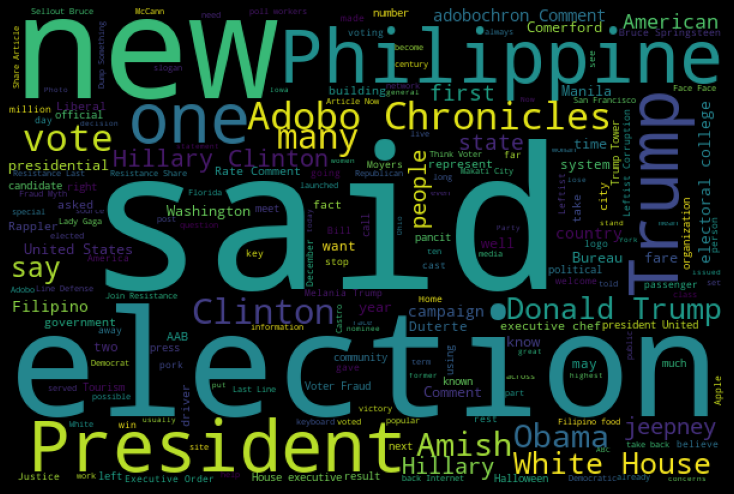

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Generate a word cloud image
fake_wordcloud = WordCloud(width=600, height=400).generate(" ".join(cleanwords))

#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(fake_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')

fake_news = fake_newss[fake_newss["type"] == "bias"]

# Join the title and text
all_text = fake_news.title.str.cat(fake_news.text, sep=' ')
all_text = all_text.astype(str)
# Tokenize. The NLTK tokenizer isn't awesome. Spacy has a nice one, but I don't think it is installed
words = nltk.word_tokenize(" ".join(all_text.tolist()))

# clearly more cleaning is needed here, but really I should get a better tokenizer
stop = stopwords.words('english') 
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


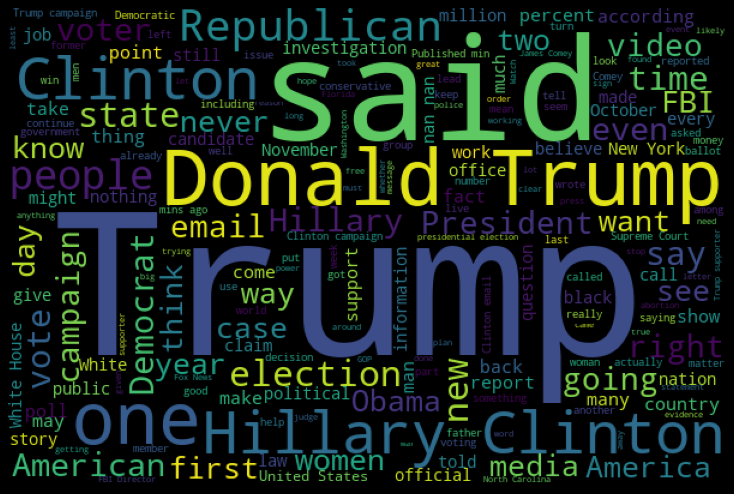

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Generate a word cloud image
bias_wordcloud = WordCloud(width=600, height=400).generate(" ".join(cleanwords))

#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(bias_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
bigrams = nltk.bigrams(cleanwords)

In [ ]:
# look at the most common. 

from collections import Counter
counter = Counter(bigrams)
print(counter.most_common(10))

[(('Donald', 'Trump'), 393), (('Hillary', 'Clinton'), 338), (('New', 'York'), 88), (('nan', 'nan'), 82), (('White', 'House'), 74), (('United', 'States'), 74), (('Clinton', 'campaign'), 73), (('Supreme', 'Court'), 72), (('Published', 'mins'), 63), (('mins', 'ago'), 63)]


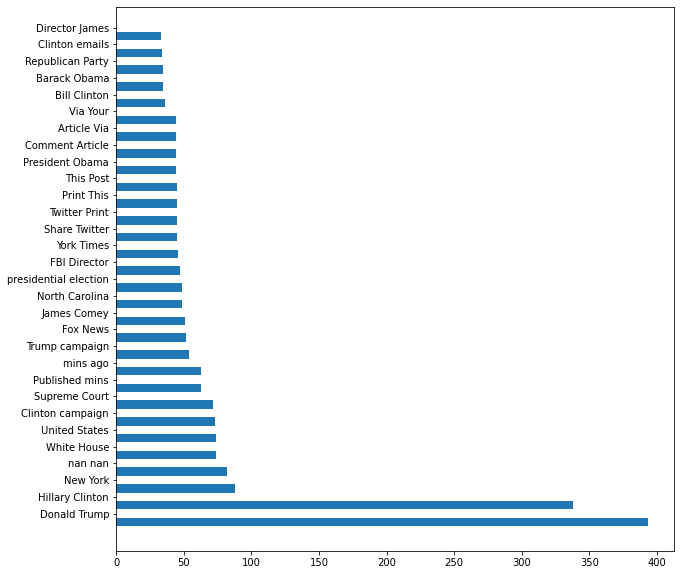

In [ ]:
num_to_show = 30

labels = [" ".join(e[0]) for e in counter.most_common(num_to_show)]
values = [e[1] for e in counter.most_common(num_to_show)]

indexes = np.arange(len(labels))
width = 0.5

#plt.bar(indexes, values, width)
#plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.figure(figsize=(10,10))
plt.barh(indexes, values, width)
plt.yticks(indexes + width, labels)

plt.show()

# Micro Factor 1 - Profanity Check

In [ ]:
!pip install profanity-check

In [ ]:
!pip install --upgrade scikit-learn==0.22.1

In [ ]:
# import joblib
from profanity_check import predict, predict_prob


def check_profanity(fake_newss):
  fake_newss['contains_profanity'] = predict(fake_newss['clean_text'])
  return fake_newss

fake_newss = check_profanity(fake_newss)
fake_newss

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.

/usr/

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_cat,readability_score,topic_number,lda_score,topic_top_words,contains_profanity
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,1,18.531957,7,0.578260,obama state govern would peopl year presid nat...,0
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,1,-115.928659,0,0.907088,clinton email investig state hillari report co...,0
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,1,-74.141154,0,0.991962,clinton email investig state hillari report co...,0
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,1,43.206897,1,0.954989,clinton trump hillari presid email campaign wo...,0
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,1,-155.693776,7,0.580373,obama state govern would peopl year presid nat...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,allow put dog face top real face b sound right...,snapchat rais billion ipo valu compani much bi...,12,0,12994,1,110.055000,8,0.887471,peopl world state time like year would nation ...,1
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,

In [ ]:
result = fake_newss[(fake_newss['contains_profanity']  == 1)]
result

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_cat,readability_score,topic_number,lda_score,topic_top_words,contains_profanity
5,8f30f5ea14c9d5914a9fe4f55ab2581772af4c31,0,Barracuda Brigade,2016-11-02T16:31:28.550+02:00,Hillary Goes Absolutely Berserk On Protester A...,Print Hillary goes absolutely berserk! She exp...,english,2016-11-02T16:31:28.550+02:00,100percentfedup.com,US,25689.0,Hillary Goes Absolutely Berserk On Protester A...,0.0,http://bb4sp.com/wp-content/uploads/2016/11/Fu...,0,1,0,0,0,bias,print hillari goe absolut berserk explod bill ...,hillari goe absolut berserk protest ralli video,121,0,5,1,-76.090744,1,0.990720,clinton trump hillari presid email campaign wo...,1
22,ee8e9d4d80c9b05f5a049f6687be1cf8a90cdc34,0,EdJenner,2016-11-15T09:43:45.343+02:00,WOW! WHITE Liberals Suggest Blacks Are Too Stu...,Go to Article Filmmaker Ami Horowitz takes to ...,english,2016-11-15T09:43:45.343+02:00,100percentfedup.com,US,25689.0,WOW! WHITE Liberals Suggest Blacks Are Too Stu...,0.0,http://conservativeangle.com/wp-content/upload...,0,1,0,0,0,bias,go articl filmmak ami horowitz take street ber...,wow white liber suggest black stupid get idsca...,53,0,22,1,20.553208,2,0.747903,trump elect vote state peopl clinton democrat ...,1
29,5c96dddf3e19affb7386519985180b9e086bea93,0,Barracuda Brigade,2016-11-23T21:54:00.000+02:00,BOOM! Kellyanne Conway Shuts Down CNN’s Cuomo,BOOM! Kellyanne Conway Shuts Down CNN’s Cuomo ...,english,2016-11-24T01:18:15.204+02:00,100percentfedup.com,US,25689.0,BOOM! Kellyanne Conway Shuts Down CNN’s Cuomo,0.0,http://bb4sp.com/wp-content/uploads/2016/11/Fu...,0,1,0,0,0,bias,boom kellyann conway shut cnn cuomo barracuda ...,boom kellyann conway shut cnn cuomo,35,0,29,1,26.281429,1,0.970959,clinton trump hillari presid email campaign wo...,1
109,e7aacfabf3903ed68a5aa056c098f2face98cee8,0,tokyowashi (noreply@blogger.com),2016-10-31T02:03:09.291+02:00,"Do Not Forgive the MSM; Alt-Media, Our Job Is ...",Jimstone.is \nOctober 29 2016 \n\nDO NOT FORGI...,english,2016-10-31T02:03:09.291+02:00,abeldanger.net,US,34478.0,"Do Not Forgive the MSM; Alt-Media, Our Job Is ...",0.0,NaN,0,1,0,0,0,bs,jimstonei octob forgiv msm msm turn hillari fb...,forgiv msm altmedia job,714,0,109,0,-656.979202,1,0.461996,clinton trump hillari presid email campaign wo...,1
147,e479b6959d80b6f3b934de0a24c71ab7a9e0f440,1,Steve smith,2016-11-01T22:22:00.000+02:00,NaN,Google David Howard......Uh oh! Google Me........,english,2016-11-02T03:48:46.543+02:00,abeldanger.net,US,34478.0,Insiders Threaten to Expose Hillary's Pedophil...,0.0,NaN,6,1,0,0,0,bs,googl david howarduh oh googl meuh oh googl th...,insid threaten expos hillari pedophil sex ring,16,0,147,1,63.695000,6,0.909984,like trump make american peopl time news state...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12970,2e757d8576f6875f1088c3cbf32eb98da1caf0d4,15,gatorengineer,2016-10-27T00:37:44.486+03:00,NaN,more like a burning bag of shit on a doorstep....,english,2016-10-27T00:37:44.486+03:00,zerohedge.com,US,2435.0,Tesla Earnings Smash Expectations After Dramat...,0.0,NaN,26,24,0,0,0,bs,like burn bag shit doorstep,tesla earn smash expect dramat chang report me...,5,0,12970,1,100.240000,9,0.819973,peopl time like year also mani make world said...,1
12972,46b5ff68beda3548cc288567159bd780cfd674ee,17,besnook,2016-10-27T00:35:00.000+03:00,NaN,non gaap has always been bullshit.,english,2016-10-27T00:37:44.567+03:00,zerohedge.com,US,2435.0,Tesla Earnings Smash Expectations After Dramat...,0.0,NaN,26,24,0,0,0,bs,non gaap alway bullshit,tesla earn smash expect dramat chang report me...,4,0,12972,1,75.875000,4,0.699927,peopl govern state pipelin said would forc ame...,1
12981,e6a50424ffbdb786f2630b32a31675a90

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


# Micro Factor 2 & 3 - POS- Adjective and Adverbs

In [ ]:
from textblob import TextBlob
from collections import Counter
txt = fake_newss['clean_text']
count = 0
adj_list = []
adv_list = []
final_list_adj = []
final_list_adv = []
def textblob_adj(text):
  blobed = TextBlob(text)
  # counts = Counter(tag for word,tag in blobed.tags)
  adj_list = []
  adv_list = []
  adj_tag_list = ['JJ','JJR','JJS']
  adv_tag_list = ['RB','RBR','RBS']
  for (a, b) in blobed.tags:
      if b in adj_tag_list:
          adj_list.append(a)
      elif b in adv_tag_list:
          adv_list.append(a)
      else:
          pass
  return adj_list, adv_list

for i in txt:
  adj_list, adv_list = textblob_adj(i)
  if not adj_list:
    final_list_adj.append(0)
  else:
    final_list_adj.append(1)
  if not adv_list:
    final_list_adv.append(0)
  else:
    final_list_adv.append(1)
  # final_list_adj.append(adj_list)
  # final_list_adv.append(adv_list)

fake_newss['adjective'] = final_list_adj
fake_newss['adverb'] = final_list_adv
fake_newss

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_cat,readability_score,topic_number,lda_score,topic_top_words,contains_profanity,adjective,adverb
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,1,18.531957,7,0.578260,obama state govern would peopl year presid nat...,0,1,1
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,1,-115.928659,0,0.907088,clinton email investig state hillari report co...,0,1,1
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,1,-74.141154,0,0.991962,clinton email investig state hillari report co...,0,1,1
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,1,43.206897,1,0.954989,clinton trump hillari presid email campaign wo...,0,1,1
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,1,-155.693776,7,0.580373,obama state govern would peopl year presid nat...,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,allow put dog face top real face b sound right...,snapchat rais billion ipo valu compani much bi...,12,0,12994,1,110.055000,8,0.887471,peopl world state time like year would nation ...,1,1,1
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To 

# Model of Microfactor 1- Profanity

In [ ]:
tfidf_vec = TfidfVectorizer(max_df=0.7,stop_words='english')

In [ ]:
X = fake_newss['clean_text']
y = fake_newss['contains_profanity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_vec = tfidf_vec.fit_transform(X_train)
X_test_vec = tfidf_vec.transform(X_test)

log_pro = LogisticRegression()
log_pro.fit(X_train_vec,y_train)

predictions = log_pro.predict(X_test_vec)
score =accuracy_score(y_test,predictions)
print(score)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.9412587412587412
[[3997    3]
 [ 249   41]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4000
           1       0.93      0.14      0.25       290

    accuracy                           0.94      4290
   macro avg       0.94      0.57      0.61      4290
weighted avg       0.94      0.94      0.92      4290



# Model of Microfactor 2- POS Adjective

In [ ]:
from sklearn.metrics import accuracy_score
X = fake_newss['clean_text']
y = fake_newss['adjective']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_vec = tfidf_vec.fit_transform(X_train)
X_test_vec = tfidf_vec.transform(X_test)

log_adj = LogisticRegression()
log_adj.fit(X_train_vec,y_train)

predictions = log_adj.predict(X_test_vec)

score =accuracy_score(y_test,predictions)
print(score)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.9708624708624709
[[  21  121]
 [   4 4144]]
              precision    recall  f1-score   support

           0       0.84      0.15      0.25       142
           1       0.97      1.00      0.99      4148

    accuracy                           0.97      4290
   macro avg       0.91      0.57      0.62      4290
weighted avg       0.97      0.97      0.96      4290



# Model of Microfactor 3- POS Adverb

In [ ]:
X = fake_newss['clean_text']
y = fake_newss['adverb']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_vec = tfidf_vec.fit_transform(X_train)
X_test_vec = tfidf_vec.transform(X_test)

log_adv = LogisticRegression()
log_adv.fit(X_train_vec,y_train)

predictions = log_adv.predict(X_test_vec)
score =accuracy_score(y_test,predictions)
print(score)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

0.9055944055944056
[[ 287  364]
 [  41 3598]]
              precision    recall  f1-score   support

           0       0.88      0.44      0.59       651
           1       0.91      0.99      0.95      3639

    accuracy                           0.91      4290
   macro avg       0.89      0.71      0.77      4290
weighted avg       0.90      0.91      0.89      4290



In [ ]:
!pip install GoogleNews
!pip install newspaper3k


# **Ingest a streaming input**

## GoogleNews API Data Extraction


In [ ]:
from google.colab import drive, files # specific to Google Colab
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
import pandas as pd
import nltk
import time
#config will allow us to access the specified url for which we are #not authorized. Sometimes we may get 403 client error while parsing #the link to download the article.
nltk.download('punkt')

user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent
googlenews=GoogleNews(start='01/01/2021',end='11/12/2021')
response = googlenews.search('Spam')
result=googlenews.result()

df=pd.DataFrame(result)
print(df.head())
for i in range(2,50):
    googlenews.getpage(i)
    result=googlenews.result()
    df=pd.DataFrame(result)
df
# download file
df.to_csv('streaming.csv')
files.download('streaming.csv')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
                                               title  ...                                                img
0                Google Spam Update Done Rolling Out  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
1  Enterprise Spam Filter Market Size by Top Comp...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
2  Cornbread Dressing with Spam and Sun-Dried Tom...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
3  Video: Google November Spam Update Done, Googl...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...
4  Google November Spam Update Done, Google Tests...  ...  data:image/gif;base64,R0lGODlhAQABAIAAAP//////...

[5 rows x 7 columns]
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Add an Additional Microfactor 4**

In [ ]:
fake_newss['text_length'] = fake_newss['clean_text'].apply(len)
fake_newss

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,clean_text,clean_thread,num_words,similarity,index,readability_cat,readability_score,topic_number,lda_score,topic_top_words,contains_profanity,adjective,adverb,text_length
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,muslim bust stole million govt benefit,46,0,0,1,18.531957,7,0.578260,obama state govern would peopl year presid nat...,0,1,1,283
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,attorney gener loretta lynch plead fifth,164,0,1,1,-115.928659,0,0.907088,clinton email investig state hillari report co...,0,1,1,1103
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,red state fox news sunday report morn anthoni ...,break weiner cooper fbi hillari email investig,130,0,2,1,-74.141154,0,0.991962,clinton email investig state hillari report co...,0,1,1,825
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email kayla mueller prison tortur isi chanc re...,pin drop speech father daughter kidnap kill is...,29,0,3,1,43.206897,1,0.954989,clinton trump hillari presid email campaign wo...,0,1,1,184
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,email healthcar reform make america great sinc...,fantast trump point plan reform healthcar begi...,196,0,4,1,-155.693776,7,0.580373,obama state govern would peopl year presid nat...,0,1,1,1304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,f1b5d0e44803f48732bde854a9fdf95837219b12,2,replaceme,2016-10-26T23:58:00.000+03:00,NaN,It DOES allow you to put a dog face on top of ...,english,2016-10-27T00:37:46.194+03:00,zerohedge.com,US,2435.0,"Snapchat To Raise Up To $4 Billion In IPO, Val...",0.000,NaN,40,32,0,0,0,bs,allow put dog face top real face b sound right...,snapchat rais billion ipo valu compani much bi...,12,0,12994,1,110.055000,8,0.887471,peopl world state time like year would nation ...,1,1,1,56
12995,36011ceba3647e1bea78299b68b6fb705a1fc1ad,3,Freedumb,2016-10-27T00:02:00.000+03:00,NaN,Wait till you see what happens to the valuatio...,english,2016-10-27T00:37:46.220+03:00,zerohedg

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



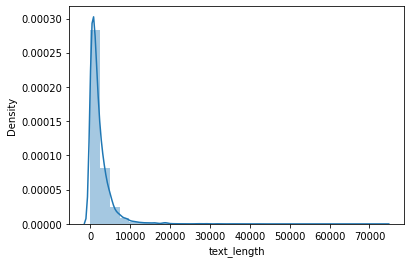

In [ ]:
sns.distplot(a=fake_newss['text_length'],bins=30)

In [ ]:
test1 = df['desc']
test1_vec = tfidf_vec.transform(test1)

# **Combine All Microfactors and Assess Veracity Factor**

In [ ]:
prob_adj = log_adj.predict_proba(test1_vec)
prob_adv = log_adv.predict_proba(test1_vec)
prob_pro = log_pro.predict_proba(test1_vec)


In [ ]:
df2 = pd.DataFrame(prob_adj[:,1],columns={'adjective'})
df3 = pd.DataFrame(prob_adv[:,1],columns={'adverb'})
df4 = pd.DataFrame(prob_pro[:,1],columns={'contains_profanity'})

In [ ]:
result_dataframe = pd.concat([df['desc'],df2,df3,df4],axis=1)

In [ ]:
result_dataframe.head()

,desc,adjective,adverb,contains_profanity
0,Google confirms an algorithm updated targeted ...,0.853892,0.461253,0.046628
1,"New Jersey, United States,- This Enterprise Sp...",0.931879,0.699733,0.028317
2,"Sweet corn, earthy sun-dried tomatoes and salt...",0.858234,0.532717,0.114199
3,I start off announcing the winner(s) of the Sq...,0.869692,0.502174,0.056213
4,Google finished the rollout for the November s...,0.854448,0.451703,0.062811


In [ ]:
accur = [ 0.97, 0.90, 0.94] # using the (normalized) accuracy as weigths

w = [float(i)/sum(accur) for i in accur]
sumW = 0
prob = []
prob.append(w[0] * result_dataframe['adjective'])
sumW += w[0]
prob.append(w[1] * result_dataframe['adverb'])
sumW += w[1]
prob.append(w[2] * result_dataframe['contains_profanity'])
sumW += w[2]
probTotal = sum(prob[0:len(prob)]) / sumW
result_dataframe['spam_final_Score'] = probTotal

In [ ]:
result_dataframe['spam_final_Score'] = result_dataframe['spam_final_Score'].round(decimals = 3)

In [ ]:
result_dataframe

,desc,adjective,adverb,contains_profanity,spam_final_Score
0,Google confirms an algorithm updated targeted ...,0.853892,0.461253,0.046628,0.458
1,"New Jersey, United States,- This Enterprise Sp...",0.931879,0.699733,0.028317,0.555
2,"Sweet corn, earthy sun-dried tomatoes and salt...",0.858234,0.532717,0.114199,0.505
3,I start off announcing the winner(s) of the Sq...,0.869692,0.502174,0.056213,0.480
4,Google finished the rollout for the November s...,0.854448,0.451703,0.062811,0.461
...,...,...,...,...,...
295,Scammers are using consumer loathing towards s...,0.926602,0.624044,0.031590,0.530
296,This Android dialer app turns battling spam ca...,0.857693,0.470570,0.061867,0.467
297,Amazon and Apple users have been hit with a sl...,0.881885,0.477303,0.071477,0.481
298,"From fried rice to burritos, the seemingly tim...",0.863051,0.458442,0.059435,0.465


In [ ]:
result_dataframe.drop(['adjective','adverb','contains_profanity'], axis = 1,inplace = True)

In [ ]:
result_dataframe.head()

,desc,spam_final_Score
0,Google confirms an algorithm updated targeted ...,0.458
1,"New Jersey, United States,- This Enterprise Sp...",0.555
2,"Sweet corn, earthy sun-dried tomatoes and salt...",0.505
3,I start off announcing the winner(s) of the Sq...,0.480
4,Google finished the rollout for the November s...,0.461


In [ ]:
result_dataframe.rename(columns={"desc": "Article"},inplace = True)

In [ ]:
pip install plotly pandas

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig1 = go.Figure(data=[go.Table(
  columnorder = [1,2],
  columnwidth = [300,80],
  header = dict(values=list(result_dataframe.columns)),
  cells=dict(values=[result_dataframe["Article"], result_dataframe['spam_final_Score']],height=70))
])
fig1.show()